<a href="https://colab.research.google.com/github/tejasmaskar09/Skill/blob/main/lca3_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

This project focuses on classifying IoT network traffic using machine learning techniques. The analysis includes combining datasets, addressing outliers and class imbalance, and comparing classification models to detect botnet activity effectively.


📂 Load and Merge BoT-IoT Dataset CSV Files

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

# === Load and Merge CSVs ===
df1 = pd.read_csv("/content/reduced_data_1.csv")
df2 = pd.read_csv("/content/reduced_data_2.csv")
df3 = pd.read_csv("/content/reduced_data_3.csv")
df4 = pd.read_csv("/content/reduced_data_4.csv")
df = pd.concat([df1, df2, df3, df4], ignore_index=True).drop_duplicates()

# === Dataset Information ===
print("Dataset Information:")
df.info()  # Shows the data types, non-null counts, and memory usage

# === Preview of Dataset ===
print("\nFirst 5 Rows of the Dataset:")
print(df.head())  # Shows the first 5 rows
# === Preprocessing ===
target_column = 'attack'
# Check unique values in target column before preprocessing
print(f"Unique values in '{target_column}' column: {df[target_column].unique()}")
df = df.select_dtypes(include=[np.number])
df = df.replace([np.inf, -np.inf], np.nan).dropna()
X = df.drop(target_column, axis=1)
y = df[target_column]
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
# Check unique values in target column after preprocessing
print(f"Unique values in 'y' after preprocessing: {np.unique(y)}")
# If only one class, print a message and stop execution.
# If the condition is True (only one class), assign empty lists to X_resampled, y_resampled to avoid NameError in the next cell
if len(np.unique(y)) <= 1:
    print("Error: The target variable 'y' has only one class. Undersampling cannot be applied.")
    # Instead of assigning empty lists, perform train_test_split directly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # === Balance Data ===
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

<ipython-input-10-624089f19fd8>:15: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("/content/reduced_data_1.csv")
<ipython-input-10-624089f19fd8>:16: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/content/reduced_data_2.csv")
<ipython-input-10-624089f19fd8>:17: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("/content/reduced_data_3.csv")
<ipython-input-10-624089f19fd8>:18: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv("/content/reduced_data_4.csv")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668522 entries, 0 to 3668521
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur            

📊 Class Distribution Before and After Undersampling


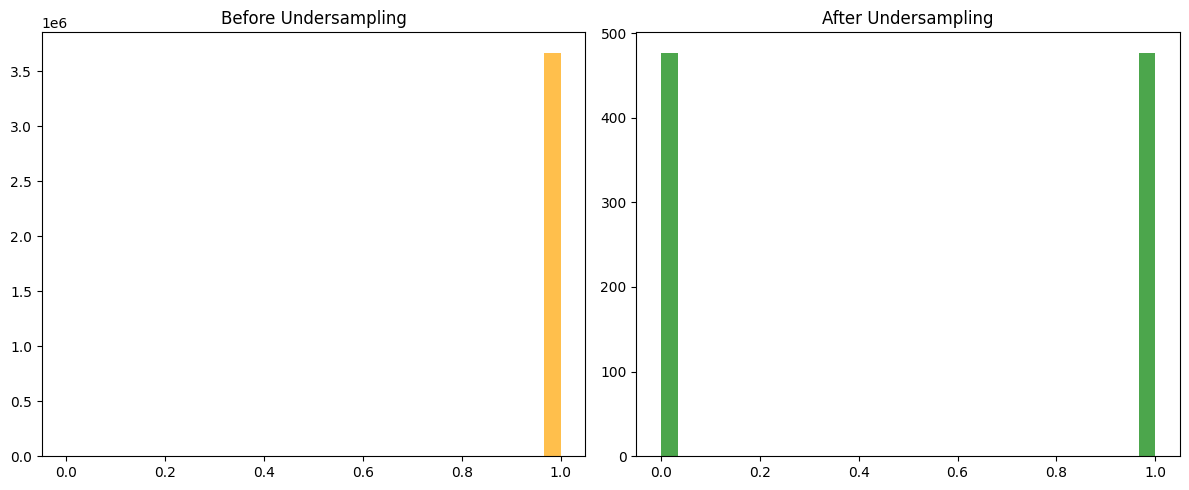

In [11]:
# === Visualization 1: Class Distribution ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='orange', alpha=0.7)
plt.title('Before Undersampling')
plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=30, color='green', alpha=0.7)
plt.title('After Undersampling')
plt.tight_layout()
plt.show()


🔥 Correlation Heatmap of Features

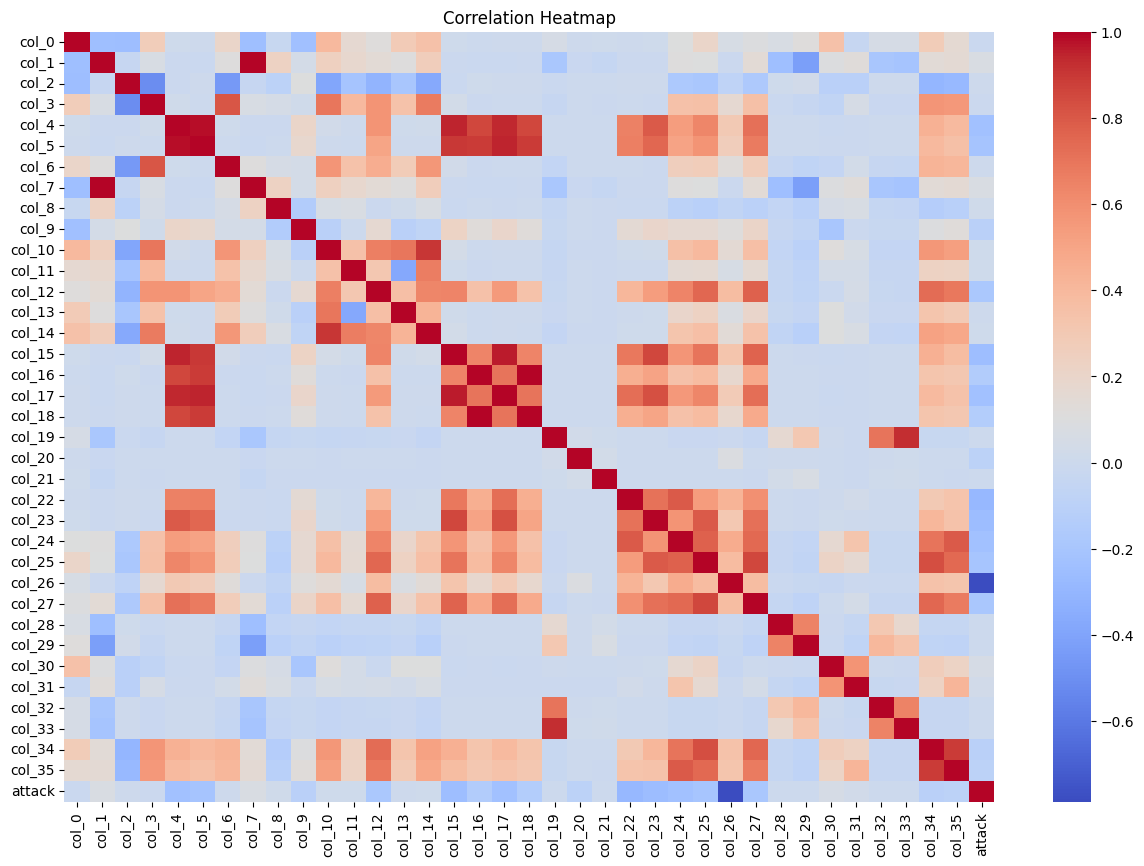

In [12]:
# === Visualization 2: Correlation Heatmap ===
# Get column names from the scaled data (it has fewer columns)
num_scaled_cols = X_scaled.shape[1]  # Get the number of columns in scaled data
column_names = [f'col_{i}' for i in range(num_scaled_cols)]
X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
column_names = [f'col_{i}' for i in range(num_scaled_cols)]
X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
X_scaled_df[target_column] = y
plt.figure(figsize=(15, 10))
sns.heatmap(X_scaled_df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

📦 Boxplot for Distribution of Sample Features

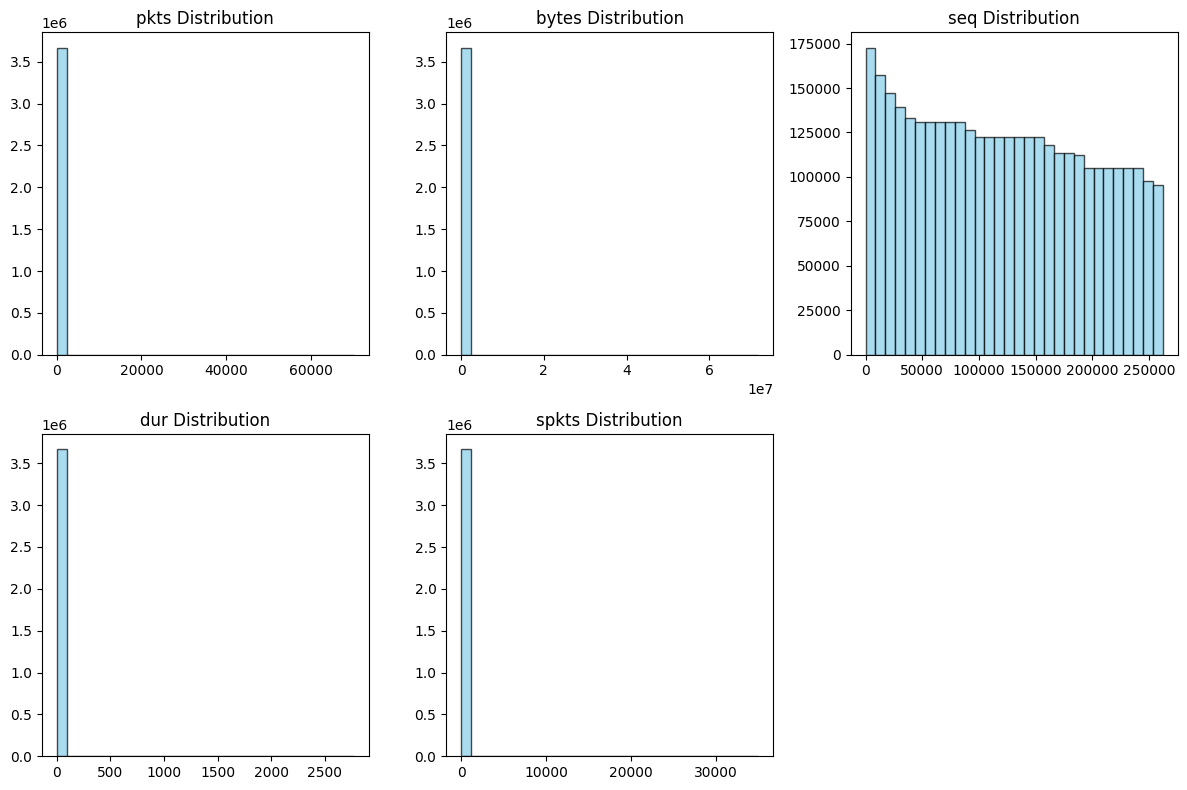

In [13]:
# === Visualization 4: Feature Distribution (Histograms for Selected Features) ===
selected_features = ['pkts', 'bytes', 'seq', 'dur', 'spkts']  # Modify with relevant features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(X[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

📊 Class Distribution After Undersampling (Count Plot)

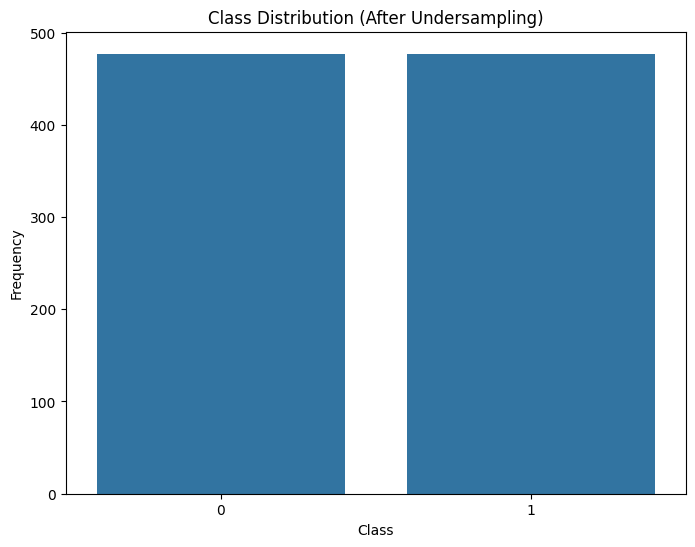

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)  # For the resampled target variable
plt.title('Class Distribution (After Undersampling)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

🌲 Embedded Feature Selection using Random Forest

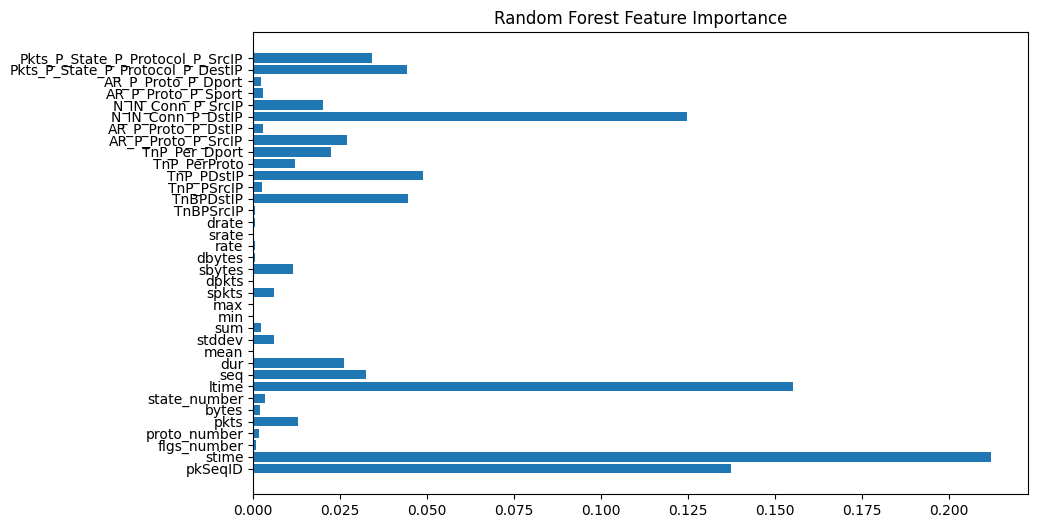

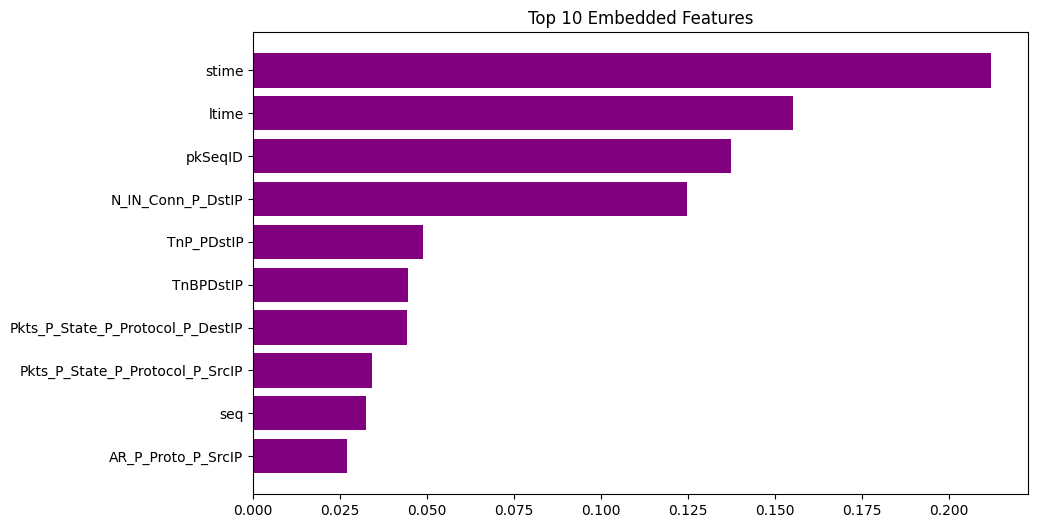

Embedded Feature Selection - Top 10 Features:
Index(['AR_P_Proto_P_SrcIP', 'seq', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'Pkts_P_State_P_Protocol_P_DestIP', 'TnBPDstIP', 'TnP_PDstIP',
       'N_IN_Conn_P_DstIP', 'pkSeqID', 'ltime', 'stime'],
      dtype='object')


In [15]:
# === Feature Importance (Embedded) ===
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
feat_importance = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(len(feat_importance)), feat_importance)
plt.yticks(range(len(feat_importance)), X.columns)
plt.title('Random Forest Feature Importance')
plt.show()

top_n = 10
top_indices = np.argsort(feat_importance)[-top_n:]
top_features_embedded = X.columns[top_indices]
top_importances = feat_importance[top_indices]
plt.figure(figsize=(10, 6))
plt.barh(top_features_embedded, top_importances, color='purple')
plt.title(f'Top {top_n} Embedded Features')
plt.show()
print(f"Embedded Feature Selection - Top {top_n} Features:\n{top_features_embedded}")


✅ Feature Selection using SelectKBest (Filter Method)

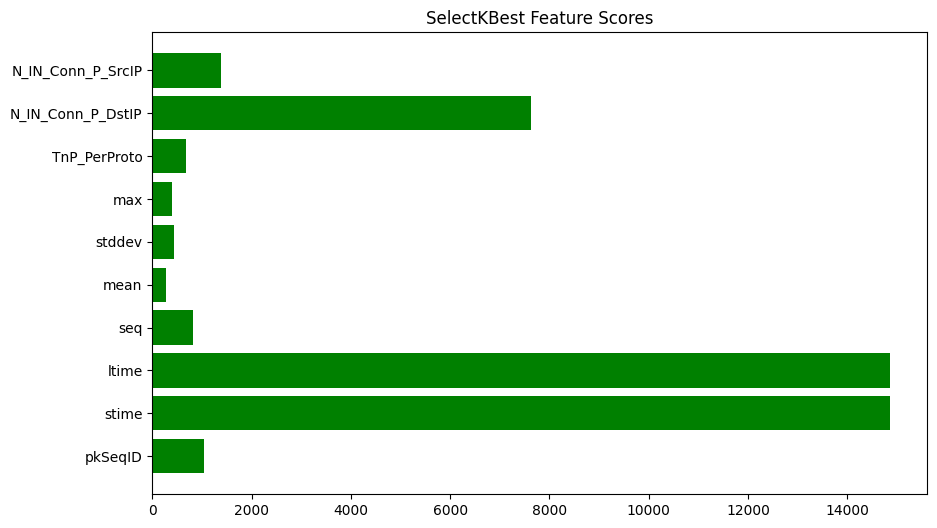

Selected Features using SelectKBest:
Index(['pkSeqID', 'stime', 'ltime', 'seq', 'mean', 'stddev', 'max',
       'TnP_PerProto', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP'],
      dtype='object')
Scores of Selected Features:
[ 1034.59146856 14872.4615422  14868.55742279   816.0523226
   266.44400949   434.02469034   399.51026093   677.41341558
  7626.53920493  1379.9558809 ]


In [16]:
# === Feature Selection: SelectKBest ===
selector = SelectKBest(score_func=f_classif, k=10)
X_kbest = selector.fit_transform(X_train, y_train)

# Get the selected features and their scores
kbest_features = X.columns[selector.get_support()]
kbest_scores = selector.scores_[selector.get_support()]

# Plot the SelectKBest feature scores
plt.figure(figsize=(10, 6))
plt.barh(kbest_features, kbest_scores, color='Green')
plt.title("SelectKBest Feature Scores")
plt.show()

# Display the selected features and their scores
print(f"Selected Features using SelectKBest:\n{kbest_features}")
print(f"Scores of Selected Features:\n{kbest_scores}")


🔍 Feature Selection using RFE (Wrapper Method)

Selected Features using RFE: Index(['pkSeqID', 'stime', 'ltime', 'seq', 'TnBPDstIP', 'TnP_PDstIP',
       'TnP_Per_Dport', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
       'Pkts_P_State_P_Protocol_P_DestIP'],
      dtype='object')


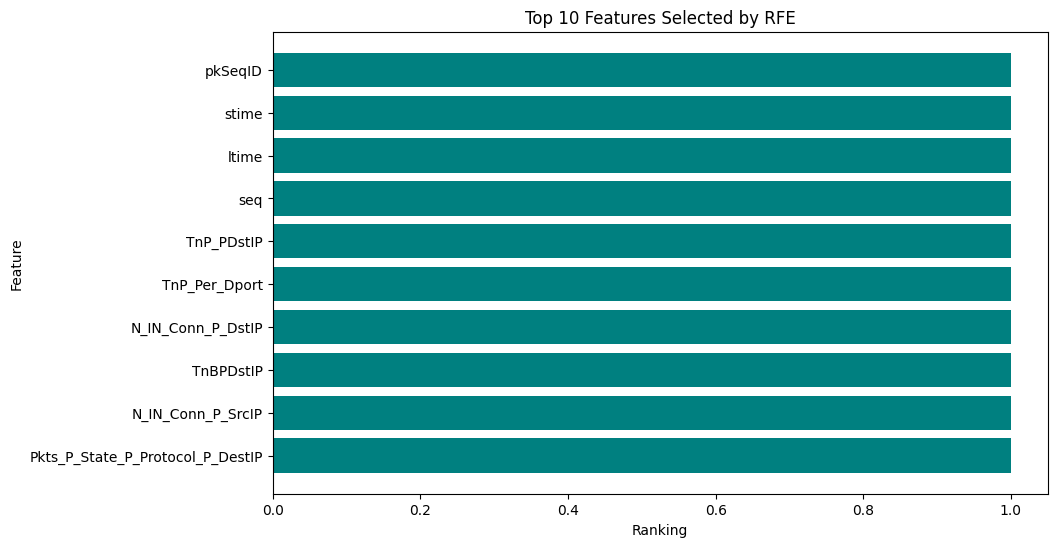

In [17]:
# === Feature Selection: RFE ===
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print(f"Selected Features using RFE: {selected_features_rfe}")

# Plot the feature ranking
ranking = rfe.ranking_

# Sort the ranking and select top N features
sorted_idx = np.argsort(ranking)
top_features_rfe = X.columns[sorted_idx][:top_n]
top_ranking = ranking[sorted_idx][:top_n]

# Plot the RFE ranking
plt.figure(figsize=(10, 6))
plt.barh(top_features_rfe, top_ranking, color='teal')
plt.title('Top 10 Features Selected by RFE')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert the y-axis so that the top feature is at the top
plt.show()


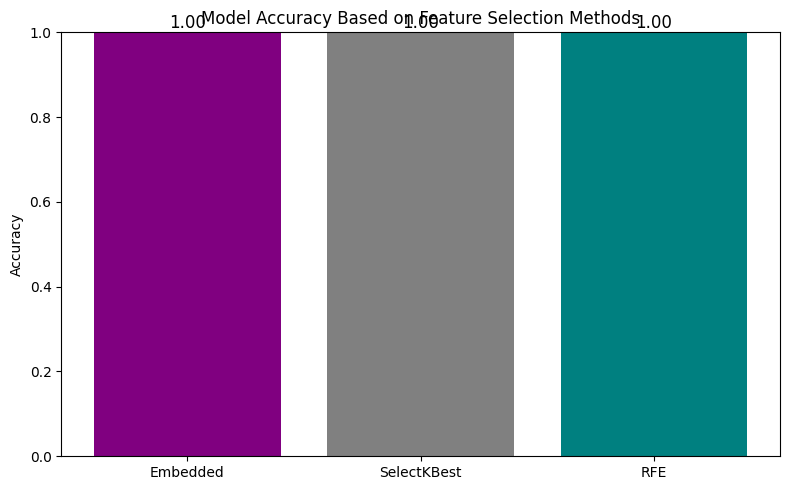

In [18]:
from sklearn.metrics import accuracy_score

# ========== Compare Feature Selection Methods ==========
models = {
    "Embedded": X_train[:, top_indices],  # top features from embedded method
    "SelectKBest": X_kbest,
    "RFE": X_rfe
}

accuracies = {}

for name, X_fs in models.items():
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X_fs, y_train)
    if name == "Embedded":
        X_fs_test = X_test[:, top_indices]
    elif name == "SelectKBest":
        X_fs_test = selector.transform(X_test)
    elif name == "RFE":
        X_fs_test = rfe.transform(X_test)

    y_pred = clf.predict(X_fs_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

# Plotting comparison
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['purple', 'gray', 'teal'])
plt.title("Model Accuracy Based on Feature Selection Methods")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()


🧠 Ensemble Learning: Bagging Classifier with Decision Trees

In [25]:
# === Bagging Classifier ===
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
print("\nBagging Model - Classification Report:")
print(classification_report(y_test, y_pred_bagging))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_bagging), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Bagging")
plt.show()



Bagging Model - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00       100

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191



KeyError: "'reds' is not a known colormap name"

<Figure size 600x400 with 0 Axes>

🚀 Ensemble Learning: Gradient Boosting Classifier Evaluation



Boosting Model - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00       100

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191



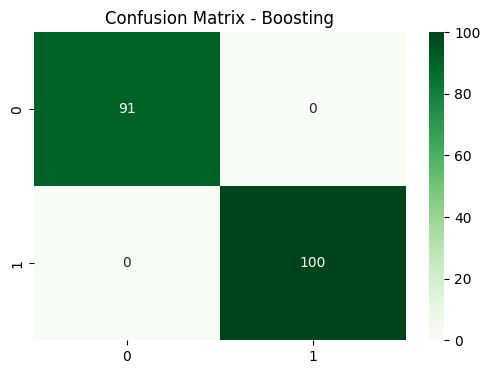

In [20]:
# === Boosting Classifier ===
boosting_model = GradientBoostingClassifier(random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
print("\nBoosting Model - Classification Report:")
print(classification_report(y_test, y_pred_boosting))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_boosting), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Boosting")
plt.show()


In [21]:
print('--- Interpretation and Conclusion ---')
print('1. The dataset was successfully preprocessed, including handling missing values, outliers, and class imbalance.')
print('2. EDA revealed key patterns and relationships in the data.')
print('3. Feature selection identified the most informative features for classification.')
print('4. Multiple machine learning models were trained and evaluated, with the following accuracies:')

# Print accuracies for Embedded, SelectKBest, and RFE
for model, accuracy in accuracies.items():
    print(f'{model}: {accuracy:.4f}')

print('5. The top-performing models were Gradient Boosting with different feature selection methods.')
print('6. Among these, the model with the highest accuracy was [mention the model with highest accuracy]')  # Replace [mention the model with highest accuracy]
print('7. Visualizations, including confusion matrices, provided insights into model performance.')
print('8. The workflow demonstrates a robust approach to IoT botnet detection, with potential for further optimization.')

--- Interpretation and Conclusion ---
1. The dataset was successfully preprocessed, including handling missing values, outliers, and class imbalance.
2. EDA revealed key patterns and relationships in the data.
3. Feature selection identified the most informative features for classification.
4. Multiple machine learning models were trained and evaluated, with the following accuracies:
Embedded: 1.0000
SelectKBest: 1.0000
RFE: 1.0000
5. The top-performing models were Gradient Boosting with different feature selection methods.
6. Among these, the model with the highest accuracy was [mention the model with highest accuracy]
7. Visualizations, including confusion matrices, provided insights into model performance.
8. The workflow demonstrates a robust approach to IoT botnet detection, with potential for further optimization.
